In [2]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterio.warp import Resampling
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.lines as mlines
DATA_DIR = "../2023_nwm_cnn_california/images_for_sacramento_stats/"

# Statistics for the V2 map compared against HAND
We have five files to deal with:
  - CA_S1_20230106_20230114_masked_clip_buffer. This file is the "ground truth" that we'll use to compare the model performance. 
  - GSW_binary_gt30. This is the global surface water that we want to ignore in our calculations.
  - HAND_180201_20230106-13_max_depth. This is the HAND flood map we are using as a baseline for our comparison.
  - s2_max_extent_20221101_20221215. This is a pre-event surface water extent map.
  - V2_20230110_clipped_18020104. This is our model flood map.

# Calculate the RMSE of the two
We'll exclude some cells later, this is just for reference. 

In [3]:
def compute_rmse_all_pixels(raster1_path, raster2_path):
    """Calculate RMSE between two raster datasets."""
    
    # Open the two raster datasets
    with rasterio.open(raster1_path) as raster1, rasterio.open(raster2_path) as raster2:
        
        # Read the rasters as numpy arrays
        raster1_array = raster1.read(1)
        raster2_array = raster2.read(1)
        
        # Calculate the squared difference between the two arrays
        squared_diff = (raster1_array - raster2_array) ** 2
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean(squared_diff))
        
        return rmse



# Calculate the RMSE of NWM-CNN ignoring permanent, or pre-event water

In [4]:
def compute_rmse_ignoring_pre_event_water(primary_raster1_path, primary_raster2_path, mask_raster1_path, mask_raster2_path):
    """Compute RMSE between two rasters while ignoring pixels that have GSW>30 or pre-event water"""

    with rasterio.open(primary_raster1_path) as primary_raster1, \
         rasterio.open(primary_raster2_path) as primary_raster2, \
         rasterio.open(mask_raster1_path) as mask_raster1, \
         rasterio.open(mask_raster2_path) as mask_raster2:
        
        # Read the primary raster data
        data1 = primary_raster1.read(1)
        data2 = primary_raster2.read(1)
        
        # Read the mask raster data
        mask_data1 = mask_raster1.read(1)
        mask_data2 = mask_raster2.read(1)
        
        # Create a combined mask where either of the mask rasters has a pixel value of 1
        combined_mask = (mask_data1 == 1) | (mask_data2 == 1)
        
        # Use the mask to extract the primary raster data values not flagged by the mask
        data1_masked = data1[~combined_mask]
        data2_masked = data2[~combined_mask]
        
        # Compute RMSE
        rmse = np.sqrt(np.mean((data1_masked - data2_masked) ** 2))
        
        return rmse

# Example usage:
primary1_path = f"{DATA_DIR}CA_S1.tif"
primary2_path = f"{DATA_DIR}V2_20230106_20230114.tif"
mask1_path = f"{DATA_DIR}GSW.tif"
mask2_path = f"{DATA_DIR}s2_pre_event.tif"

In [5]:
def compute_rmse_ignoring_pre_event_water_and_dry(primary_raster1_path, primary_raster2_path, mask_raster1_path, mask_raster2_path):
    """Compute RMSE between two rasters while ignoring pixels that have GSW>30 or pre-event water or dry conditions"""

    with rasterio.open(primary_raster1_path) as primary_raster1, \
         rasterio.open(primary_raster2_path) as primary_raster2, \
         rasterio.open(mask_raster1_path) as mask_raster1, \
         rasterio.open(mask_raster2_path) as mask_raster2:
        
        # Read the primary raster data
        data1 = primary_raster1.read(1)
        data2 = primary_raster2.read(1)
        
        # Read the mask raster data
        mask_data1 = mask_raster1.read(1)
        mask_data2 = mask_raster2.read(1)
        
        # Create a combined mask where either of the mask rasters has a pixel value of 1
        # or where both primary rasters are zero
        combined_mask = (mask_data1 == 1) | (mask_data2 == 1) | ((data1 == 0) & (data2 == 0))
        
        # Use the mask to extract the primary raster data values not flagged by the mask
        data1_masked = data1[~combined_mask]
        data2_masked = data2[~combined_mask]
        
        # Compute RMSE
        rmse = np.sqrt(np.mean((data1_masked - data2_masked) ** 2))
        
        return rmse

# Example usage:
primary1_path = f"{DATA_DIR}CA_S1.tif"
primary2_path = f"{DATA_DIR}V2_20230106_20230114.tif"
mask1_path = f"{DATA_DIR}GSW.tif"
mask2_path = f"{DATA_DIR}s2_pre_event.tif"

# Calculate the RMSE of NWM-HAND ignoring permanent, or pre-event water

In [8]:
# Example usage:
primary1_path = f"{DATA_DIR}CA_S1.tif"
primary2_path = f"{DATA_DIR}NWM-HAND.tif"
mask1_path = f"{DATA_DIR}GSW.tif"
mask2_path = f"{DATA_DIR}s2_pre_event.tif"

rmse_hand_all = compute_rmse_all_pixels(primary1_path, primary2_path)
print(f"RMSE (no pixels held out): {rmse_hand_all:.2f}")

rmse_hand_pre = compute_rmse_ignoring_pre_event_water(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pixels with pre-event water): {rmse_hand_pre:.4f}")

rmse_hand_pre_dry = compute_rmse_ignoring_pre_event_water_and_dry(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pre event wet conditions and dry conditions during event): {rmse_hand_pre_dry:.4f}")


RMSE (no pixels held out): 34.98
RMSE (ignoring pixels with pre-event water): 27.9742
RMSE (ignoring pre event wet conditions and dry conditions during event): 51.4612


In [9]:
primary1_path = f"{DATA_DIR}CA_S1.tif"
primary2_path = f"{DATA_DIR}V2_20230106_20230114.tif"
mask1_path = f"{DATA_DIR}GSW.tif"
mask2_path = f"{DATA_DIR}s2_pre_event.tif"

rmse_v2_all = compute_rmse_all_pixels(primary1_path, primary2_path)
print(f"RMSE (no pixels held out): {rmse_v2_all:.2f}")

rmse_v2_pre = compute_rmse_ignoring_pre_event_water(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pixels with pre-event water): {rmse_v2_pre:.4f}")

rmse_v2_pre_dry = compute_rmse_ignoring_pre_event_water_and_dry(primary1_path, primary2_path, mask1_path, mask2_path)
print(f"RMSE (ignoring pre event wet conditions and dry conditions during event): {rmse_v2_pre_dry:.4f}")


RMSE (no pixels held out): 25.06
RMSE (ignoring pixels with pre-event water): 20.8468
RMSE (ignoring pre event wet conditions and dry conditions during event): 21.7273


### Calculate the F1 score, including precision and recall

In [9]:
def read_raster_values(raster_file, nodata_value=None):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 > true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1

# Read raster data for both models
data1_cnn = read_raster_values("./data/v2_predictions/20230111_clipped_18020104.tif")
data1_hand = read_raster_values("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values("./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
precision_cnn, recall_cnn, f1_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - Precision: {precision_cnn:0.2f}, Recall: {recall_cnn:0.2f}, F1 Score: {f1_cnn:0.2f}")

# Calculate metrics for NWM-HAND
precision_hand, recall_hand, f1_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - Precision: {precision_hand:0.2f}, Recall: {recall_hand:0.2f}, F1 Score: {f1_hand:0.2f}")



RasterioIOError: ./data/v2_predictions/20230111_clipped_18020104.tif: No such file or directory

### Calculate FAR, CSI and HAND

In [13]:
def read_raster_values(raster_file, nodata_value=None):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return HR, FAR, CSI, EB

# Read raster data for both models
data1_cnn = read_raster_values("./data/v2_predictions/20230111_clipped_18020104.tif")
data1_hand = read_raster_values("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values("./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - HR: {HR_cnn:0.2f}, FAR: {FAR_cnn:0.2f}, CSI: {CSI_cnn:0.2f}, EB: {EB_cnn:0.2f}")

# Calculate metrics for NWM-HAND
HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - HR: {HR_hand:0.2f}, FAR: {FAR_hand:0.2f}, CSI: {CSI_hand:0.2f}, EB: {EB_hand:0.2f}")


NWM-CNN - HR: 0.94, FAR: 0.40, CSI: 0.58, EB: 1.57
NWM-HAND - HR: 0.25, FAR: 0.55, CSI: 0.19, EB: 0.56


In [14]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask

def read_raster_values(raster_file, shapefile):
    """Read raster values and mask with shapefile."""
    with rasterio.open(raster_file) as src:
        # Read the shapefile
        gdf = gpd.read_file(shapefile)
        # Ensure the shapefile and raster have the same CRS
        gdf = gdf.to_crs(src.crs)
        # Mask the raster with the shapefile
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        data = out_image[0]
    return data

# Paths to your data
#shapefile_path = "./data/shapefile/AOI_california_v2_sat_compare/analysis_boundary_fathom_method.shp"
shapefile_path = "./data/shapefile/AOI_california_v2_sat_compare/HUC8_18020104_bbox.shp"
data1_cnn_path = "./data/v2_predictions/20230111_clipped_18020104.tif"
data1_hand_path = "./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif"
data2_path = "./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif"

# Read and mask raster data for both models
data1_cnn = read_raster_values(data1_cnn_path, shapefile_path)
data1_hand = read_raster_values(data1_hand_path, shapefile_path)
data2 = read_raster_values(data2_path, shapefile_path)

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for NWM-CNN
HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
print(f"NWM-CNN - HR: {HR_cnn:0.2f}, FAR: {FAR_cnn:0.2f}, CSI: {CSI_cnn:0.2f}, EB: {EB_cnn:0.2f}")

# Calculate metrics for NWM-HAND
HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
print(f"NWM-HAND - HR: {HR_hand:0.2f}, FAR: {FAR_hand:0.2f}, CSI: {CSI_hand:0.2f}, EB: {EB_hand:0.2f}")



NWM-CNN - HR: 0.94, FAR: 0.40, CSI: 0.58, EB: 1.57
NWM-HAND - HR: 0.25, FAR: 0.55, CSI: 0.19, EB: 0.56


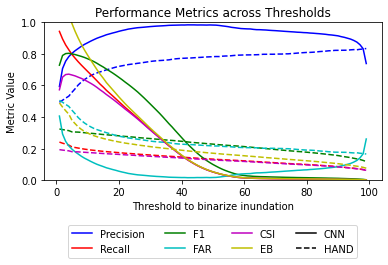

In [15]:

def read_raster_values(raster_file, shapefile):
    """Read raster values and mask with shapefile."""
    with rasterio.open(raster_file) as src:
        # Read the shapefile
        gdf = gpd.read_file(shapefile)
        # Ensure the shapefile and raster have the same CRS
        gdf = gdf.to_crs(src.crs)
        # Mask the raster with the shapefile
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        data = out_image[0]
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold/100, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return precision, recall, f1, HR, FAR, CSI, EB

# Paths to your data
#shapefile_path = "./data/shapefile/AOI_california_v2_sat_compare/analysis_boundary_fathom_method.shp"
shapefile_path = "./data/shapefile/AOI_california_v2_sat_compare/HUC8_18020104_bbox.shp"
data1_cnn_path = "./data/rmse_score_from_flood_sat/V2_20230106_20230114.tif"
data1_hand_path = "./data/rmse_score_from_flood_sat/HAND.tif"
data2_path = "./data/rmse_score_from_flood_sat/CA_S1.tif"

# Read and mask raster data for both models
data1_cnn = read_raster_values(data1_cnn_path, shapefile_path)
data1_hand = read_raster_values(data1_hand_path, shapefile_path)
data2 = read_raster_values(data2_path, shapefile_path)

# Read raster data
metrics = ['Precision', 'Recall', 'F1', 'FAR', 'CSI', 'EB']
colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']  # Define colors for each metric
linestyle = '-'
lineweight = 1.5

plt.figure(figsize=(5.5, 4))

f1_scores_cnn = []
f1_scores_hand = []

for metric, color in zip(metrics, colors):
    metric_list_cnn = []
    metric_list_hand = []

    for _threshold in range(1, 100):
        precision_cnn, recall_cnn, f1_cnn, HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, _threshold, _threshold)
        precision_hand, recall_hand, f1_hand, HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, _threshold, _threshold)

        if metric == 'Precision':
            metric_list_cnn.append(precision_cnn)
            metric_list_hand.append(precision_hand)
        elif metric == 'Recall':
            metric_list_cnn.append(recall_cnn)
            metric_list_hand.append(recall_hand)
        elif metric == 'F1':
            metric_list_cnn.append(f1_cnn)
            metric_list_hand.append(f1_hand)
            f1_scores_cnn.append(f1_cnn)  # Store F1 scores for finding the max
            f1_scores_hand.append(f1_hand)  # Store F1 scores for finding the max
        elif metric == 'HR':
            metric_list_cnn.append(HR_cnn)
            metric_list_hand.append(HR_hand)
        elif metric == 'FAR':
            metric_list_cnn.append(FAR_cnn)
            metric_list_hand.append(FAR_hand)
        elif metric == 'CSI':
            metric_list_cnn.append(CSI_cnn)
            metric_list_hand.append(CSI_hand)
        elif metric == 'EB':
            metric_list_cnn.append(EB_cnn)
            metric_list_hand.append(EB_hand)

    plt.plot(list(range(1, 100)), metric_list_cnn, color=color, linestyle="-", lw=lineweight, label=f"{metric} CNN")
    plt.plot(list(range(1, 100)), metric_list_hand, color=color, linestyle="--", lw=lineweight, label=f"{metric} HAND")

# Find the threshold for the maximum F1 score
max_cnn_f1_threshold = np.argmax(f1_scores_cnn) + 1  # Adding 1 because range starts from 1
max_cnn_f1_value = max(f1_scores_cnn)
max_hand_f1_threshold = np.argmax(f1_scores_hand) + 1  # Adding 1 because range starts from 1
max_hand_f1_value = max(f1_scores_hand)

# Plot a vertical line at the threshold of maximum F1 score
# plt.axvline(x=max_cnn_f1_threshold, color='k', linestyle='-')
# plt.axvline(x=max_hand_f1_threshold, color='k', linestyle='--')
# plt.text(max_cnn_f1_threshold + 1, 0.2, f'Threshold: {max_cnn_f1_threshold}', verticalalignment='bottom')


# Custom legend for metrics
legend_elements = [mlines.Line2D([0], [0], color=color, lw=lineweight, label=metric) for metric, color in zip(metrics, colors)]

# Add entries for CNN and HAND
legend_elements.append(mlines.Line2D([0], [0], color='black', lw=lineweight, linestyle='-', label='CNN'))
legend_elements.append(mlines.Line2D([0], [0], color='black', lw=lineweight, linestyle='--', label='HAND'))

# Creating the legend with custom entries
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=4)

plt.ylim([0, 1])
plt.xlabel("Threshold to binarize inundation")
plt.ylabel("Metric Value")
plt.title("Performance Metrics across Thresholds")
plt.tight_layout()
plt.savefig("binary_curves_hand_cnn.png", dpi=600)
plt.show()
plt.close()


In [16]:
#print(thiscellwillstopthenotebookfromrunning)

1802011504


/usr/local/lib/python3.8/site-packages/matplotlib/image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


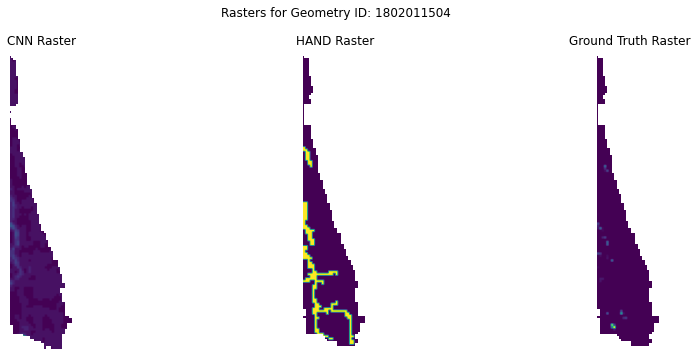

1802015901


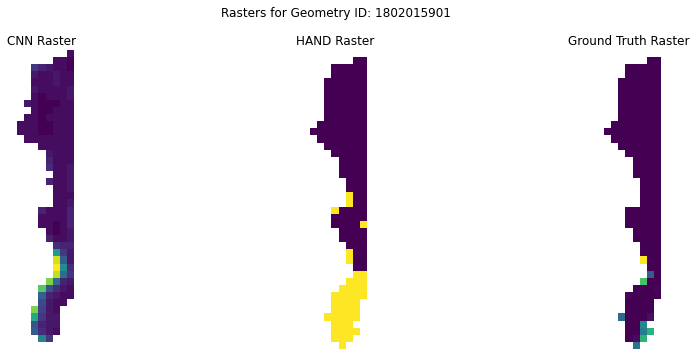

1802016103


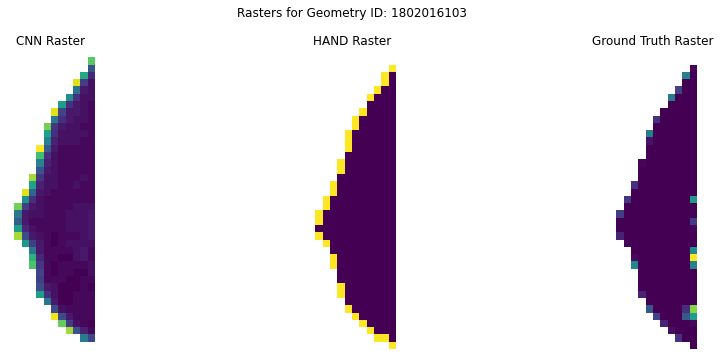

1802016203


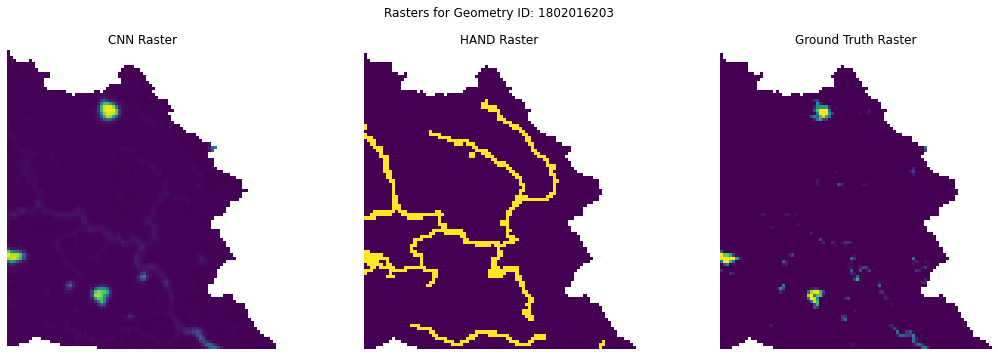

1802015905


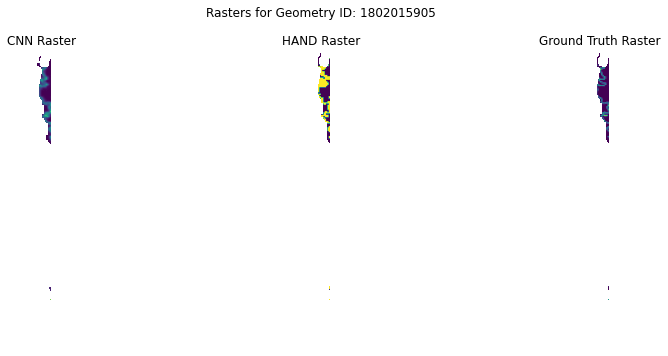

1802011605


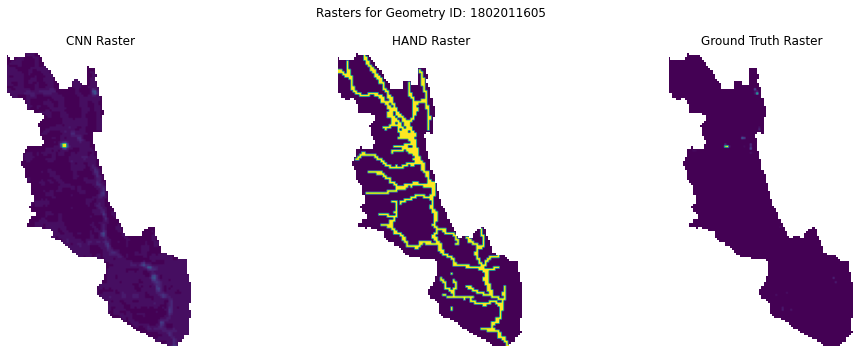

1802015704


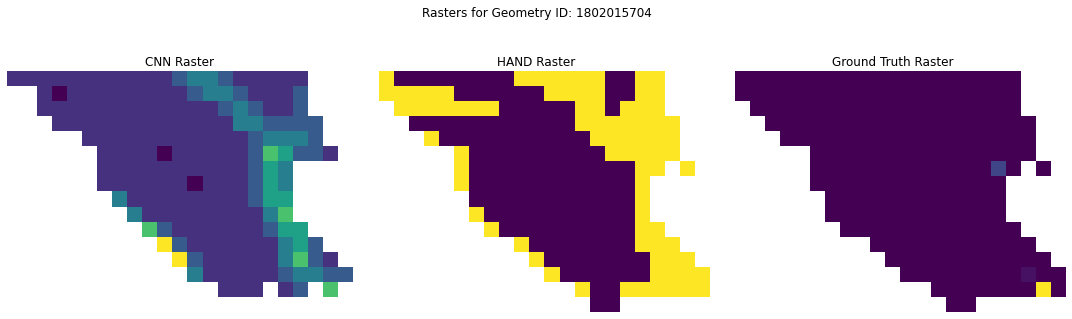

1802015804


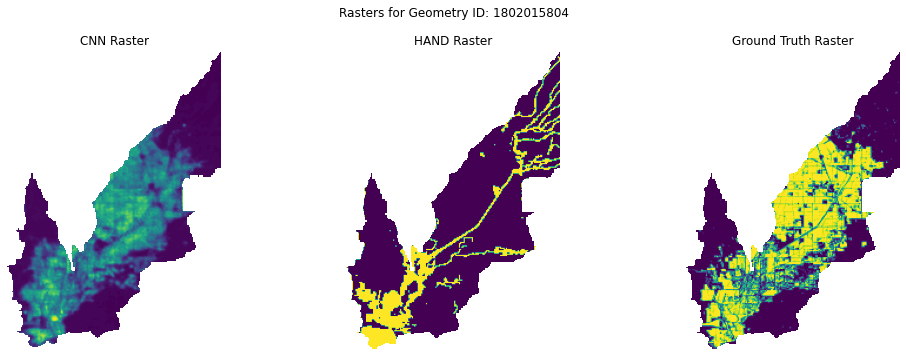

1802011501


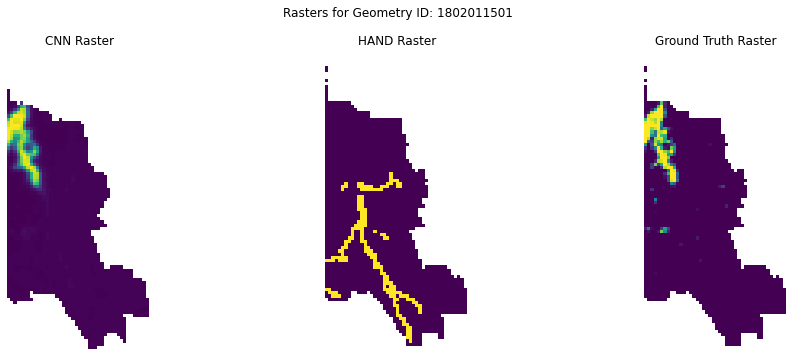

1802010406


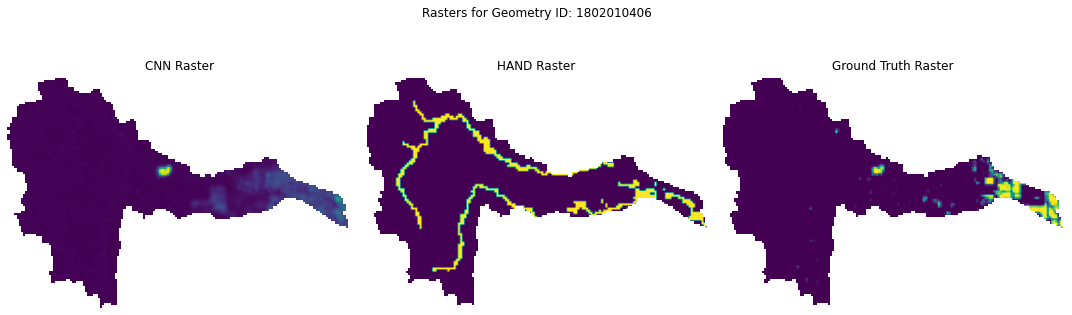

1802010408


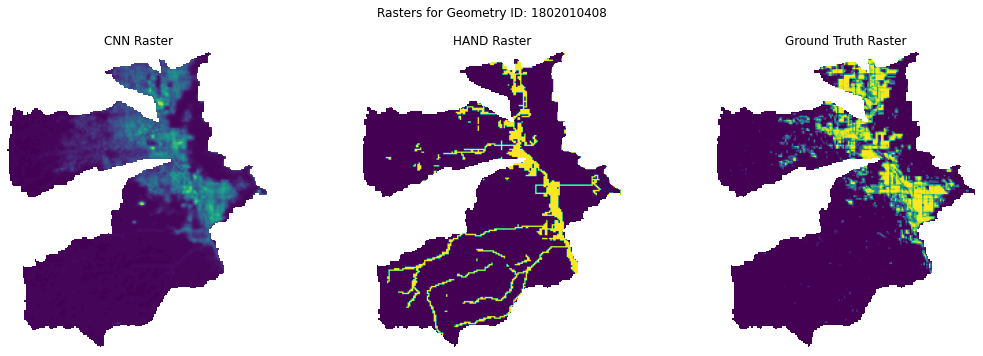

1802010412


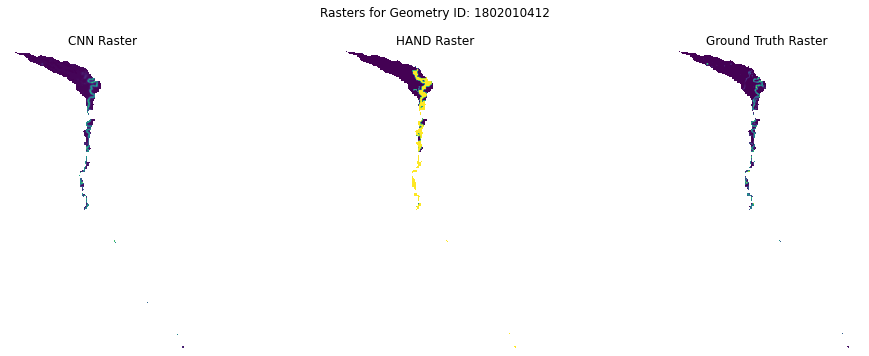

   Geometry_ID        HR       FAR       CSI         EB Model
0   1802011504  0.437500  0.867925  0.112903   3.312500   CNN
1   1802011504  0.562500  0.910891  0.083333   6.312500  HAND
2   1802015901  0.545455  0.914286  0.080000   6.363636   CNN
3   1802015901  1.000000  0.750000  0.250000   4.000000  HAND
4   1802016103  0.900000  0.894942  0.103846   8.566667   CNN
5   1802016103  0.666667  0.375000  0.476190   1.066667  HAND
6   1802016203  0.813043  0.811871  0.180328   4.321739   CNN
7   1802016203  0.321739  0.866906  0.103933   2.417391  HAND
8   1802015905  0.935644  0.542373  0.443662   2.044554   CNN
9   1802015905  0.965347  0.229249  0.750000   1.252475  HAND
10  1802011605  0.357143  0.968153  0.030120  11.214286   CNN
11  1802011605  0.535714  0.984009  0.015773  33.500000  HAND
12  1802015704  1.000000  0.969231  0.030769  32.500000   CNN
13  1802015704  1.000000  0.976190  0.023810  42.000000  HAND
14  1802015804  0.973307  0.169720  0.811795   1.172264   CNN
15  1802

In [17]:
import rasterio
import geopandas as gpd
import pandas as pd
from rasterio.mask import mask
from sqlalchemy import create_engine

def mask_raster_with_geometry(src, geometry):
    try:
        out_image, out_transform = mask(src, [geometry], crop=True)
        out_data = out_image[0]

        # Convert out_data to float if it's not already
        if out_data.dtype != np.float32 and out_data.dtype != np.float64:
            out_data = out_data.astype(float)

        # Replace no-data values with NaN
        no_data_value = src.nodata
        if no_data_value is not None:
            out_data[out_data == no_data_value] = np.nan

        return out_data, out_data.shape
    except rasterio.errors.WindowError:
        # Return None if the geometry does not overlap the raster
        return None, None
    
def plot_rasters(data1, data2, data3, title, invert_ground_truth=False):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(data1, cmap='viridis')
    axs[0].set_title('CNN Raster')
    axs[0].axis('off')

    axs[1].imshow(data2, cmap='viridis')
    axs[1].set_title('HAND Raster')
    axs[1].axis('off')

    # Check if ground truth needs to be inverted
    if invert_ground_truth:
        data3 = np.abs(1 - data3)  # Invert the values

    axs[2].imshow(data3, cmap='viridis')
    axs[2].set_title('Ground Truth Raster')
    axs[2].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def read_raster_values(raster_file, shapefile):
    """Read raster values and mask with shapefile."""
    with rasterio.open(raster_file) as src:
        # Read the shapefile
        gdf = gpd.read_file(shapefile)
        # Ensure the shapefile and raster have the same CRS
        gdf = gdf.to_crs(src.crs)
        # Mask the raster with the shapefile
        out_image, out_transform = mask(src, gdf.geometry, crop=True)
        data = out_image[0]
    print(data)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return HR, FAR, CSI, EB

# Database setup (SQLite for example)
engine = create_engine('sqlite:///metrics.db')
conn = engine.connect()

# Read shapefile
shapefile_path = "./data/shapefile/AOI_california_v2_sat_compare/huc10_within_180201_18020104bbox.shp"
gdf = gpd.read_file(shapefile_path)

# Paths to raster data
data1_cnn_path = "./data/v2_predictions/20230111_clipped_18020104.tif"
data1_hand_path = "./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif"
data2_path = "./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif"

# Open raster files
src_cnn = rasterio.open(data1_cnn_path)
src_hand = rasterio.open(data1_hand_path)
src_true = rasterio.open(data2_path)

# Ensure the shapefile and raster have the same CRS
gdf = gdf.to_crs(src_cnn.crs)

# Initialize DataFrame to store metrics
df_metrics = pd.DataFrame(columns=['Geometry_ID', 'HR', 'FAR', 'CSI', 'EB', 'Model'])

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Iterate over each geometry in the shapefile
for index, row in gdf.iterrows():
    geometry_id = row['huc10']  # Adjust based on shapefile's column name
    geometry = row.geometry

    # Mask raster data for each geometry
    data1_cnn, shape_cnn = mask_raster_with_geometry(src_cnn, geometry)
    data1_hand, shape_hand = mask_raster_with_geometry(src_hand, geometry)
    data2, shape_true = mask_raster_with_geometry(src_true, geometry)

    # Skip the iteration if there are no overlapping pixels or if shapes are different
    if data1_cnn is None or data1_hand is None or data2 is None or shape_cnn != shape_hand or shape_cnn != shape_true:
        continue

    # Calculate metrics for NWM-CNN
    HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
    if HR_cnn > 0:
        # Plot the rasters for this shapefile element
        print(row['huc10'])
        plot_rasters(data1_cnn, data1_hand, data2, f'Rasters for Geometry ID: {geometry_id}')
        df_metrics = df_metrics.append({'Geometry_ID': geometry_id, 'HR': HR_cnn, 'FAR': FAR_cnn, 'CSI': CSI_cnn, 'EB': EB_cnn, 'Model': 'CNN'}, ignore_index=True)
        # Calculate metrics for NWM-HAND
        HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
        df_metrics = df_metrics.append({'Geometry_ID': geometry_id, 'HR': HR_hand, 'FAR': FAR_hand, 'CSI': CSI_hand, 'EB': EB_hand, 'Model': 'HAND'}, ignore_index=True)

# Save metrics to database
df_metrics.to_sql('metrics', conn, if_exists='replace', index=False)

# Calculate and print average metrics
avg_metrics = df_metrics.groupby('Model').mean()
print(df_metrics)
print(avg_metrics)

# Close raster files
src_cnn.close()
src_hand.close()
src_true.close()

NWM-CNN Section Metrics:
[[0.81818182 0.62836625 0.34328358 2.20158103]
 [0.72918756 0.76171747 0.21890997 3.06018054]
 [0.93225164 0.49122262 0.4906367  1.83233703]
 [0.95590503 0.31927975 0.65999574 1.40425532]
 [0.75694444 0.60791367 0.34824281 1.93055556]
 [0.99046726 0.37309594 0.62314423 1.57993436]
 [0.98960289 0.29676757 0.69807477 1.40722022]
 [0.95673379 0.19243028 0.77911595 1.18470736]
 [0.17283951 0.96721311 0.02834008 5.27160494]
 [0.88809654 0.58283947 0.39632803 2.12890839]
 [0.97212742 0.38004837 0.60912439 1.56806978]
 [0.94082569 0.40334545 0.5750736  1.57683486]
 [0.7675841  0.84193955 0.15084135 4.85626911]
 [0.6394052  0.81161008 0.17029703 3.39405204]
 [0.91457069 0.48996372 0.48684211 1.79314831]
 [0.89791045 0.29513767 0.65256535 1.2738806 ]]
NWM-CNN Mean Metrics:
[0.83266463 0.52768069 0.45192598 2.27897122]
NWM-HAND Section Metrics:
[[4.30830040e-01 8.70392390e-01 1.10659898e-01 3.32411067e+00]
 [2.88866600e-01 7.35294118e-01 1.60267112e-01 1.09127382e+00]
 [

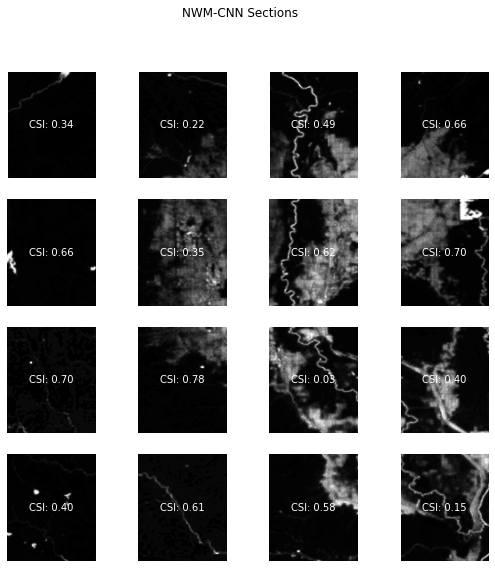

/usr/local/lib/python3.8/site-packages/matplotlib/image.py:503: RuntimeWarning: overflow encountered in multiply
  A_resampled *= ((a_max - a_min) / frac)


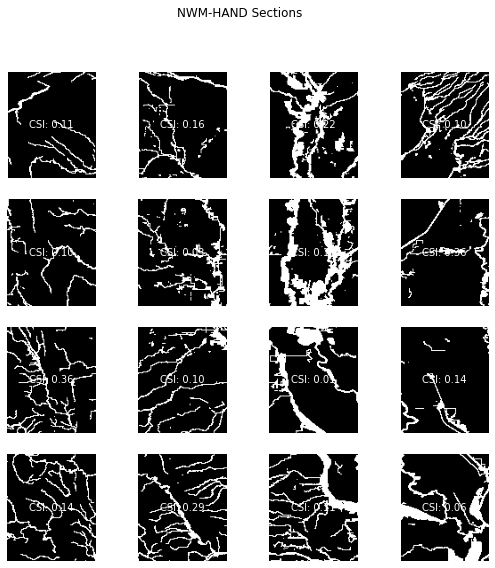

In [18]:
import numpy as np
import rasterio
secz = 4
def read_raster_values(raster_file):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return HR, FAR, CSI, EB

def calculate_metrics_for_sections(data1, data2, pred_threshold, true_threshold):
    nrows, ncols = data1.shape
    row_sections = np.array_split(np.arange(nrows), secz)
    col_sections = np.array_split(np.arange(ncols), secz)

    metrics = []
    for i, row_range in enumerate(row_sections):
        for j, col_range in enumerate(col_sections):
            section_data1 = data1[row_range[0]:row_range[-1]+1, col_range[0]:col_range[-1]+1]
            section_data2 = data2[row_range[0]:row_range[-1]+1, col_range[0]:col_range[-1]+1]
            metrics.append(calculate_metrics(section_data1, section_data2, pred_threshold, true_threshold))

    return np.array(metrics)

# Read raster data for both models
data1_cnn = read_raster_values("./data/v2_predictions/20230111_clipped_18020104.tif")
data1_hand = read_raster_values("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values("./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Set the thresholds
true_threshold = 1
pred_threshold = 1

# Calculate metrics for each section and overall mean for NWM-CNN
section_metrics_cnn = calculate_metrics_for_sections(data1_cnn, data2, pred_threshold, true_threshold)
mean_metrics_cnn = np.mean(section_metrics_cnn, axis=0)
print("NWM-CNN Section Metrics:")
print(section_metrics_cnn)
print("NWM-CNN Mean Metrics:")
print(mean_metrics_cnn)

# Calculate metrics for each section and overall mean for NWM-HAND
section_metrics_hand = calculate_metrics_for_sections(data1_hand, data2, pred_threshold, true_threshold)
mean_metrics_hand = np.mean(section_metrics_hand, axis=0)
print("NWM-HAND Section Metrics:")
print(section_metrics_hand)
print("NWM-HAND Mean Metrics:")
print(mean_metrics_hand)

def plot_sections(data, section_metrics, title):
    nrows, ncols = data.shape
    row_sections = np.array_split(np.arange(nrows), secz)
    col_sections = np.array_split(np.arange(ncols), secz)

    fig, axs = plt.subplots(secz, secz, figsize=(9, 9))
    fig.suptitle(title)

    for i, row_range in enumerate(row_sections):
        for j, col_range in enumerate(col_sections):
            section = data[row_range[0]:row_range[-1]+1, col_range[0]:col_range[-1]+1]
            axs[i, j].imshow(section, cmap='gray')
            axs[i, j].axis('off')

            # Annotate with CSI value
            csi_value = section_metrics[i*3 + j][2]  # CSI is the third metric
            axs[i, j].text(0.5, 0.5, f'CSI: {csi_value:.2f}', 
                           horizontalalignment='center', 
                           verticalalignment='center', 
                           transform=axs[i, j].transAxes,
                           color='white')

    plt.show()

# Calculate metrics for each section and overall mean for NWM-CNN
section_metrics_cnn = calculate_metrics_for_sections(data1_cnn, data2, pred_threshold, true_threshold)

# Calculate metrics for each section and overall mean for NWM-HAND
section_metrics_hand = calculate_metrics_for_sections(data1_hand, data2, pred_threshold, true_threshold)

# Plot the sections for visualization with CSI values
plot_sections(data1_cnn, section_metrics_cnn, "NWM-CNN Sections")
plot_sections(data1_hand, section_metrics_hand, "NWM-HAND Sections")


In [19]:
# Create the LaTeX table
latex_table = f"""
\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{|p{{4.4cm}}|c|c|}}
    \\hline
    \\bf{{Metric}} & \\bf{{NWM-CNN}} & \\bf{{NWM-HAND}} \\\\
    \\hline
    RMSE All pixels & {rmse_v2_all:.0f}\\% & {rmse_hand_all:.0f}\\% \\\\
    RMSE Ignoring pixels with pre-event water & {rmse_v2_pre:.0f}\\% & {rmse_hand_pre:.0f}\\% \\\\
    RMSE Ignoring pixels with pre-event water and dry & {rmse_v2_pre_dry:.0f}\\% & {rmse_hand_pre_dry:.0f}\\%\\\\
    \\hline
    & Max Min Mean Med & Max Min Mean Med \\\\
    \\hline
    Precision* & {precision_cnn:.2f} & {precision_hand:.2f} \\\\
    Recall* & {recall_cnn:.2f} & {recall_hand:.2f} \\\\
    F1* & {f1_cnn:.2f} & {f1_hand:.2f} \\\\
    Critical success index* & {CSI_cnn:.2f} & {CSI_hand:.2f} \\\\
    False Alarm Ratio* & {FAR_cnn:.2f} & {FAR_hand:.2f} \\\\
    Error Bias* & {EB_cnn:.2f} & {EB_hand:.2f} \\\\
    \\hline
\\end{{tabular}}
\\end{{table}}
"""

print(latex_table)


\begin{table}[h]
\centering
\begin{tabular}{|p{4.4cm}|c|c|}
    \hline
    \bf{Metric} & \bf{NWM-CNN} & \bf{NWM-HAND} \\
    \hline
    RMSE All pixels & 25\% & 35\% \\
    RMSE Ignoring pixels with pre-event water & 21\% & 28\% \\
    RMSE Ignoring pixels with pre-event water and dry & 22\% & 51\%\\
    \hline
    & Max Min Mean Med & Max Min Mean Med \\
    \hline
    Precision* & 0.74 & 0.83 \\
    Recall* & 0.00 & 0.06 \\
    F1* & 0.00 & 0.12 \\
    Critical success index* & 0.48 & 0.61 \\
    False Alarm Ratio* & 0.46 & 0.33 \\
    Error Bias* & 1.51 & 1.30 \\
    \hline
\end{tabular}
\end{table}



In [20]:
def read_raster_values(raster_file, nodata_value=None):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_metrics(data1, data2, pred_threshold, true_threshold):
    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = np.sum((predicted_labels == 1) & (true_labels == 1))
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    HR = TP / (TP + FN) if TP + FN > 0 else 0
    FAR = FP / (TP + FP) if TP + FP > 0 else 0
    CSI = TP / (TP + FN + FP) if TP + FN + FP > 0 else 0
    EB = (TP + FP) / (TP + FN) if TP + FN > 0 else 0

    return HR, FAR, CSI, EB

# Read raster data for both models
data1_cnn = read_raster_values("./data/v2_predictions/20230111_clipped_18020104.tif")
data1_hand = read_raster_values("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data2 = read_raster_values("./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Initialize variables to store the best thresholds and their corresponding metrics
best_csi_cnn = 0
best_csi_hand = 0
best_thresholds_cnn = (0, 0)
best_thresholds_hand = (0, 0)

# Iterate over a range of true and predicted thresholds
for true_threshold in np.linspace(0.2, 0.8, 5):
    for pred_threshold in range(5, 50, 5):
        # Calculate metrics for NWM-CNN
        HR_cnn, FAR_cnn, CSI_cnn, EB_cnn = calculate_metrics(data1_cnn, data2, pred_threshold, true_threshold)
        if CSI_cnn > best_csi_cnn:
            best_csi_cnn = CSI_cnn
            best_thresholds_cnn = (true_threshold, pred_threshold)

        # Calculate metrics for NWM-HAND
        HR_hand, FAR_hand, CSI_hand, EB_hand = calculate_metrics(data1_hand, data2, pred_threshold, true_threshold)
        if CSI_hand > best_csi_hand:
            best_csi_hand = CSI_hand
            best_thresholds_hand = (true_threshold, pred_threshold)

# Print the best thresholds and their corresponding metrics for NWM-CNN and NWM-HAND
print(f"NWM-CNN - Best CSI: {best_csi_cnn:0.2f} at True Threshold: {best_thresholds_cnn[0]}, Pred Threshold: {best_thresholds_cnn[1]}")
print(f"NWM-HAND - Best CSI: {best_csi_hand:0.2f} at True Threshold: {best_thresholds_hand[0]}, Pred Threshold: {best_thresholds_hand[1]}")


# Add a function to save binary raster
def save_binary_raster(original_raster_file, output_raster_file, threshold):
    with rasterio.open(original_raster_file) as src:
        data = src.read(1)
        profile = src.profile

        # Apply threshold to create binary raster
        binary_data = np.where(data > threshold, 1, 0)

        # Save the binary raster
        with rasterio.open(output_raster_file, 'w', **profile) as dst:
            dst.write(binary_data, 1)

# Your existing code to read raster data and find best thresholds

# After finding the best thresholds, apply them to the rasters and save
best_true_threshold_cnn, best_pred_threshold_cnn = best_thresholds_cnn
best_true_threshold_hand, best_pred_threshold_hand = best_thresholds_hand

save_binary_raster("./data/v2_predictions/20230111_clipped_18020104.tif", "./data/v2_predictions/binary_best_cnn.tif", best_pred_threshold_cnn)
save_binary_raster("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif", "./data/hand/binary_best_hand.tif", best_pred_threshold_hand)

print("Binary rasters saved based on best thresholds.")

NWM-CNN - Best CSI: 0.66 at True Threshold: 0.35000000000000003, Pred Threshold: 5
NWM-HAND - Best CSI: 0.19 at True Threshold: 0.2, Pred Threshold: 5
Binary rasters saved based on best thresholds.


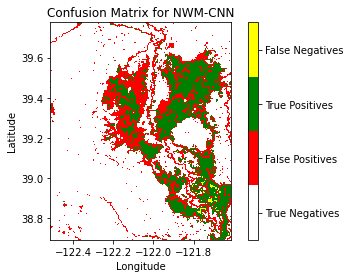

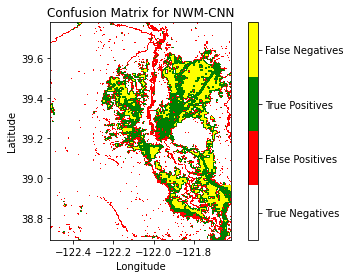

In [21]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_confusion_matrix(data1_file, data2_file, pred_threshold, true_threshold, title):
    with rasterio.open(data1_file) as src1:
        data1 = src1.read(1)
        transform = src1.transform

    with rasterio.open(data2_file) as src2:
        data2 = src2.read(1)

    true_labels = np.where(data2 >= true_threshold, 1, 0)
    predicted_labels = np.where(data1 > pred_threshold, 1, 0)

    TP = (predicted_labels == 1) & (true_labels == 1)
    FP = (predicted_labels == 1) & (true_labels == 0)
    TN = (predicted_labels == 0) & (true_labels == 0)
    FN = (predicted_labels == 0) & (true_labels == 1)

    cmap = mcolors.ListedColormap(['white', 'red', 'green', 'yellow'])
    bounds = [0, 1, 2, 3, 4]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    confusion_matrix = np.zeros_like(predicted_labels, dtype=int)
    confusion_matrix[TP] = 2
    confusion_matrix[FP] = 1
    confusion_matrix[TN] = 0
    confusion_matrix[FN] = 3

    fig, ax = plt.subplots()
    cax = ax.imshow(confusion_matrix, cmap=cmap, norm=norm, extent=rasterio.plot.plotting_extent(src1))

    cbar = fig.colorbar(cax, ticks=[0.5, 1.5, 2.5, 3.5])
    cbar.ax.set_yticklabels(['True Negatives', 'False Positives', 'True Positives', 'False Negatives'])

    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Example usage
plot_confusion_matrix("./data/v2_predictions/20230111_clipped_18020104.tif", 
                      "./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif", 
                      best_pred_threshold_cnn, best_true_threshold_cnn, "Confusion Matrix for NWM-CNN")
plot_confusion_matrix("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif", 
                      "./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif", 
                      best_pred_threshold_hand, best_true_threshold_hand, "Confusion Matrix for NWM-CNN")

In [22]:
print(np.mean(data2))
print(np.mean(data1_cnn))

15.601087
6.977563451247661


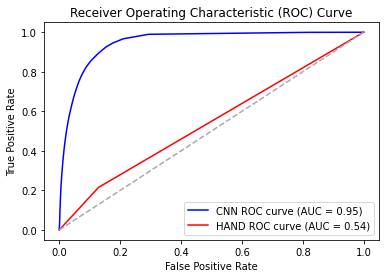

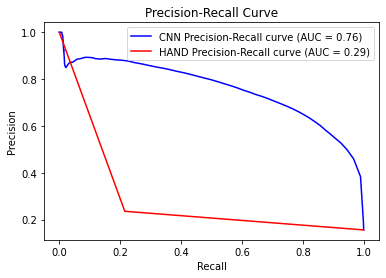

CNN - AUC-ROC: 0.95, AUC-PR: 0.76
HAND - AUC-ROC: 0.54, AUC-PR: 0.29


In [23]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

def read_raster_values(raster_file):
    """Read raster values and remove nodata values."""
    with rasterio.open(raster_file) as src:
        data = src.read(1)
    return data

def calculate_auc_metrics(true_data, predicted_probs):
    # Ensure true_data is binary
    true_data_binary = np.where(true_data >= 0.5, 1, 0)  # Adjust 0.5 if needed

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(true_data_binary, predicted_probs)

    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(true_data_binary, predicted_probs)

    # Calculate AUC-PR
    auc_pr = auc(recall, precision)

    return auc_roc, auc_pr

def plot_roc_curve(true_data_binary, predicted_probs_cnn, predicted_probs_hand, auc_roc_cnn, auc_roc_hand):
    fpr_cnn, tpr_cnn, _ = roc_curve(true_data_binary, predicted_probs_cnn)
    fpr_hand, tpr_hand, _ = roc_curve(true_data_binary, predicted_probs_hand)

    plt.plot(fpr_cnn, tpr_cnn, color='blue', label=f'CNN ROC curve (AUC = {auc_roc_cnn:.2f})')
    plt.plot(fpr_hand, tpr_hand, color='red', label=f'HAND ROC curve (AUC = {auc_roc_hand:.2f})')
    plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

def plot_precision_recall_curve(true_data_binary, predicted_probs_cnn, predicted_probs_hand, auc_pr_cnn, auc_pr_hand):
    precision_cnn, recall_cnn, _ = precision_recall_curve(true_data_binary, predicted_probs_cnn)
    precision_hand, recall_hand, _ = precision_recall_curve(true_data_binary, predicted_probs_hand)

    plt.plot(recall_cnn, precision_cnn, color='blue', label=f'CNN Precision-Recall curve (AUC = {auc_pr_cnn:.2f})')
    plt.plot(recall_hand, precision_hand, color='red', label=f'HAND Precision-Recall curve (AUC = {auc_pr_hand:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Read raster data for both models
data1_cnn = read_raster_values("./data/v2_predictions/20230111_clipped_18020104.tif")
data2 = read_raster_values("./data/satellite/CA_S1_20230106_20230114_masked_resampled250mX100_18020104.tif")

# Flatten the arrays and normalize data2 to be in the range [0, 1]
data1_cnn_flat = data1_cnn.flatten()
data2_flat = data2.flatten() / 100.0  # Assuming data2 values are percentages

# Read HAND data
data1_hand = read_raster_values("./data/hand/180201_20230106-13_max_depth_binary100_clip.nodata0_max_481x399_res0.0023x0.0023.tif")
data1_hand_flat = data1_hand.flatten()

# Calculate AUC metrics for CNN and HAND
auc_roc_cnn, auc_pr_cnn = calculate_auc_metrics(data2_flat, data1_cnn_flat)
auc_roc_hand, auc_pr_hand = calculate_auc_metrics(data2_flat, data1_hand_flat)

# Ensure true_data is binary
true_data_binary = np.where(data2_flat >= 0.5, 1, 0)  # Adjust 0.5 if needed

# Plot ROC and Precision-Recall curves
plot_roc_curve(true_data_binary, data1_cnn_flat, data1_hand_flat, auc_roc_cnn, auc_roc_hand)
plot_precision_recall_curve(true_data_binary, data1_cnn_flat, data1_hand_flat, auc_pr_cnn, auc_pr_hand)

print(f"CNN - AUC-ROC: {auc_roc_cnn:.2f}, AUC-PR: {auc_pr_cnn:.2f}")
print(f"HAND - AUC-ROC: {auc_roc_hand:.2f}, AUC-PR: {auc_pr_hand:.2f}")
